# Lab 07

- Diego Andrés Alonzo Medinilla 20172
- Arturo Herberto Argueta Ávila 21527

## Libraries

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
%pip install numpy matplotlib seaborn pandas
%pip install gymnasium

Looking in indexes: https://download.pytorch.org/whl/cu124Note: you may need to restart the kernel to use updated packages.



DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy in c:\python311\lib\site-packages (1.24.3)



DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
%pip install pyglet==1.3.2 gym==0.22 pyvirtualdisplay

DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [3]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [4]:
# Ambiente
import gymnasium as gym
from gym.wrappers import Monitor, RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay
# Virtualizacion
from collections import deque
from IPython import display as ipythondisplay
from IPython.display import HTML
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import glob
import io
import base64

## Crear el ambiente

In [5]:
env = gym.make('CartPole-v1')
num_features = env.observation_space.shape[0]
num_actions = env.action_space.n

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Redes de linea y destino

In [7]:
class DQN(nn.Module):
    """Dense neural network class."""
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 32)
        self.fc2 = nn.Linear(32, 32)
        self.out = nn.Linear(32, num_actions)

    def forward(self, states):
        """Forward pass."""
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        return self.out(x)

# Linea
main_nn = DQN(num_features, num_actions).to(device)
# Destino
target_nn = DQN(num_features, num_actions).to(device)

optimizer = torch.optim.Adam(main_nn.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

## Hiperparámetros

In [8]:
# Hyperparameters.
num_episodes = 1000
epsilon = 1.0
batch_size = 32
discount = 0.99
cur_frame = 0

## Epsilon greedy

In [9]:
def select_epsilon_greedy_action(state, epsilon):
  """Take random action with probability epsilon, else take best action."""
  result = np.random.uniform()
  if result < epsilon:
    return env.action_space.sample() # Random action (left or right).
  else:
    qs = main_nn(state).cpu().data.numpy()
    return np.argmax(qs) # Greedy action for state.

## Reproduccion de la experiencia

In [10]:
class ReplayBuffer(object):
  """Experience replay buffer that samples uniformly."""
  def __init__(self, size, device="cpu"):
    """Initializes the buffer."""
    self.buffer = deque(maxlen=size)
    self.device = device

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def __len__(self):
    return len(self.buffer)

  def sample(self, num_samples):
    states, actions, rewards, next_states, dones = [], [], [], [], []
    idx = np.random.choice(len(self.buffer), num_samples)
    for i in idx:
      elem = self.buffer[i]
      state, action, reward, next_state, done = elem
      states.append(np.array(state, copy=False))
      actions.append(np.array(action, copy=False))
      rewards.append(reward)
      next_states.append(np.array(next_state, copy=False))
      dones.append(done)
    states = torch.as_tensor(np.array(states), device=self.device)
    actions = torch.as_tensor(np.array(actions), device=self.device)
    rewards = torch.as_tensor(
        np.array(rewards, dtype=np.float32), device=self.device
    )
    next_states = torch.as_tensor(np.array(next_states), device=self.device)
    dones = torch.as_tensor(np.array(dones, dtype=np.float32), device=self.device)
    return states, actions, rewards, next_states, dones

buffer = ReplayBuffer(100000, device=device)

## Ciclo de entrenamiento

In [11]:
def train_step(states, actions, rewards, next_states, dones):
  """Perform a training iteration on a batch of data sampled from the experience
  replay buffer.
  """
  # Calculate targets.
  max_next_qs = target_nn(next_states).max(-1).values
  target = rewards + (1.0 - dones) * discount * max_next_qs
  qs = main_nn(states)
  action_masks = F.one_hot(actions, num_actions)
  masked_qs = (action_masks * qs).sum(dim=-1)
  loss = loss_fn(masked_qs, target.detach())
  #nn.utils.clip_grad_norm_(loss, max_norm=10)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [12]:
# Start training. Play game once and then train with a batch.
rewards_history = []
for episode in range(num_episodes+1):
  state, _ = env.reset()
  state = state.astype(np.float32)
  ep_reward, done = 0, False
  while not done:
    state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
    action = select_epsilon_greedy_action(state_in, epsilon)
    next_state, reward, done = env.step(action)[:3]
    next_state = next_state.astype(np.float32)
    ep_reward += reward
    # Save to experience replay.
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1
    # Copy main_nn weights to target_nn.
    if cur_frame % 2000 == 0:
      target_nn.load_state_dict(main_nn.state_dict())
    
    # Train neural network.
    if len(buffer) > batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = train_step(states, actions, rewards, next_states, dones)

  if episode < 950:
    epsilon -= 0.001

  rewards_history.append(ep_reward)

  if episode % 50 == 0:
    print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}.'
          f' Reward in last 100 episodes: {np.mean(rewards_history):.2f}')
    
env.close()

Episode 0/1000. Epsilon: 0.999. Reward in last 100 episodes: 29.00
Episode 50/1000. Epsilon: 0.949. Reward in last 100 episodes: 19.65
Episode 100/1000. Epsilon: 0.899. Reward in last 100 episodes: 19.83
Episode 150/1000. Epsilon: 0.849. Reward in last 100 episodes: 20.62
Episode 200/1000. Epsilon: 0.799. Reward in last 100 episodes: 21.78
Episode 250/1000. Epsilon: 0.749. Reward in last 100 episodes: 24.08
Episode 300/1000. Epsilon: 0.699. Reward in last 100 episodes: 26.05
Episode 350/1000. Epsilon: 0.649. Reward in last 100 episodes: 28.57
Episode 400/1000. Epsilon: 0.599. Reward in last 100 episodes: 34.07
Episode 450/1000. Epsilon: 0.549. Reward in last 100 episodes: 40.57
Episode 500/1000. Epsilon: 0.499. Reward in last 100 episodes: 49.79
Episode 550/1000. Epsilon: 0.449. Reward in last 100 episodes: 59.27
Episode 600/1000. Epsilon: 0.399. Reward in last 100 episodes: 68.69
Episode 650/1000. Epsilon: 0.349. Reward in last 100 episodes: 79.81
Episode 700/1000. Epsilon: 0.299. Rew

## Representar el entorno

In [13]:
def show_video():
  """Enables video recording of gym environment and shows it."""
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Video not found")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [14]:
# Wrap the environment to enable video recording
def wrap_env(env):
    # Save video to './video' directory
    env = RecordVideo(env, video_folder='./video', episode_trigger=lambda x: True)
    return env

env = wrap_env(gym.make('CartPole-v1', render_mode='rgb_array'))

# Your CartPole training logic goes here (same as before)

def show_video():
    """Enables video recording of gym environment and shows it."""
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Video not found")

# After training, show the video
show_video()


c:\Python311\Lib\site-packages\gym\wrappers\record_video.py:41: UserWarning: WARN: Overwriting existing videos at e:\Universidad\2024\Deep-Learning\Lab7\Deep-Learning\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


## Supervisar el entrenamiento

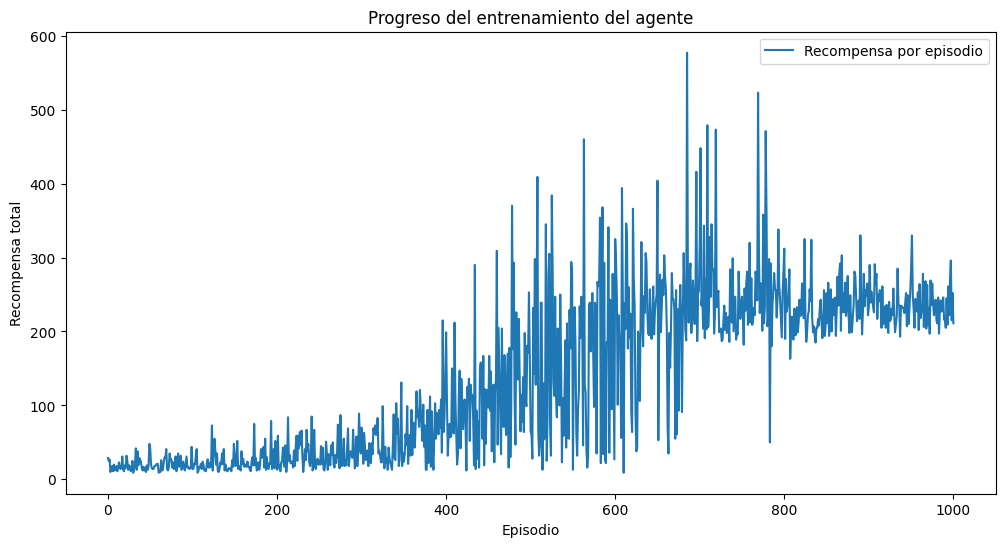

In [15]:
import matplotlib.pyplot as plt

# Graficar la recompensa total obtenida en cada episodio
plt.figure(figsize=(12, 6))
plt.plot(range(len(rewards_history)), rewards_history, label='Recompensa por episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa total')
plt.title('Progreso del entrenamiento del agente')
plt.legend()
plt.show()

## Evaluar el rendimiento

In [17]:
import numpy as np

# Calcular estadísticas
mean_reward = np.mean(rewards_history)
std_reward = np.std(rewards_history)
max_reward = np.max(rewards_history)
min_reward = np.min(rewards_history)

print("\nResultados del Entrenamiento:")
print(f"Recompensa Promedio: {mean_reward:.2f}")
print(f"Desviación Estándar: {std_reward:.2f}")
print(f"Recompensa Máxima: {max_reward}")
print(f"Recompensa Mínima: {min_reward}")


Resultados del Entrenamiento:
Recompensa Promedio: 134.97
Desviación Estándar: 107.57
Recompensa Máxima: 577.0
Recompensa Mínima: 9.0


## Fine Tuning

In [20]:
## Hyperparameters.
num_episodes = 1000
epsilon = 1.0
batch_size = 32
discount = 0.90
cur_frame = 0


env = gym.make('CartPole-v1')
num_features = env.observation_space.shape[0]
num_actions = env.action_space.n

# Start training. Play game once and then train with a batch.

# Linea
main_nn = DQN(num_features, num_actions).to(device)
# Destino
target_nn = DQN(num_features, num_actions).to(device)

optimizer = torch.optim.Adam(main_nn.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

rewards_history = []
for episode in range(num_episodes+1):
  state, _ = env.reset()
  state = state.astype(np.float32)
  ep_reward, done = 0, False
  while not done:
    state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
    action = select_epsilon_greedy_action(state_in, epsilon)
    next_state, reward, done = env.step(action)[:3]
    next_state = next_state.astype(np.float32)
    ep_reward += reward
    # Save to experience replay.
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1
    # Copy main_nn weights to target_nn.
    if cur_frame % 2000 == 0:
      target_nn.load_state_dict(main_nn.state_dict())
    
    # Train neural network.
    if len(buffer) > batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = train_step(states, actions, rewards, next_states, dones)

  if episode < 950:
    epsilon -= 0.001

  rewards_history.append(ep_reward)

  if episode % 50 == 0:
    print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}.'
          f' Reward in last 100 episodes: {np.mean(rewards_history):.2f}')
    
env.close()


# Graficar la recompensa total obtenida en cada episodio
plt.figure(figsize=(12, 6))
plt.plot(range(len(rewards_history)), rewards_history, label='Recompensa por episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa total')
plt.title('Progreso del entrenamiento del agente con finetunning')
plt.legend()
plt.show()

# Calcular estadísticas
mean_reward = np.mean(rewards_history)
std_reward = np.std(rewards_history)
max_reward = np.max(rewards_history)
min_reward = np.min(rewards_history)

print("\nResultados del Entrenamiento:")
print(f"Recompensa Promedio: {mean_reward:.2f}")
print(f"Desviación Estándar: {std_reward:.2f}")
print(f"Recompensa Máxima: {max_reward}")
print(f"Recompensa Mínima: {min_reward}")

ValueError: too many values to unpack (expected 4)

## Task 2


### Proximal Policy Optimization
Algoritmo basado en políticas que optimiza el desempeño de un agente ajustando su política directamente. A diferencia de otros métodos de optimización como TRPO (que restringen de manera más estricta los cambios en la política), PPO utiliza una versión suavizada que limita la magnitud de los cambios en la política para evitar actualizaciones demasiado grandes. Esto se logra usando un clip sobre el ratio de probabilidad entre la política nueva y la anterior, lo que facilita la implementación y mejora la estabilidad.

#### Aplicaciones:


- Robótica
- Simulaciones físicas complejas (e.g., OpenAI Gym, MuJoCo)
- Juegos de video como los entornos de Atari
- PPO es ideal cuando se necesita estabilidad y simplicidad en la optimización de la política.

#### Problemas típicos:
- Tareas de control continuo
- Ambientes con alta dimensionalidad y estados continuos
- Juegos multijugador donde las políticas cambian continuamente

### Deep Deterministic Policy Gradient (DDPG)

algoritmo off-policy que combina el enfoque de Q-learning y algoritmos de políticas. Utiliza redes neuronales para aproximar la política determinista, lo que permite que el agente seleccione acciones continuas. DDPG es un algoritmo basado en actores y críticos (actor-critic), donde el actor decide qué acción tomar y el crítico evalúa qué tan buena es esa acción dada una política. También emplea un "replay buffer" para almacenar experiencias y un mecanismo de ruido exploratorio para encontrar políticas óptimas.

##### Aplicaciones:

- Control de brazos robóticos
- Conducción autónoma
- Simulaciones físicas complejas con alta dimensionalidad de acciones

##### Problemas típicos:
- Control de movimiento en robótica
- Simulación de sistemas físicos donde las acciones deben tomarse en valores continuos

### Trust Region Policy Optimization (TRPO)

algoritmo que busca mejorar la política de un agente ajustando los parámetros de la política, pero restringiendo el cambio de la política para evitar cambios drásticos que podrían desestabilizar el entrenamiento. TRPO hace esto optimizando una función objetivo sujeta a una restricción de región de confianza (trust region), que asegura que la política actual no se aleje demasiado de la anterior durante la actualización.

#### Aplicaciones:

- Robótica
- Juegos complejos como Go o StarCraft
- Control autónomo en simulaciones
- TRPO es excelente cuando se necesita garantizar que las actualizaciones sean seguras y no desestabilicen la política actual.

#### Problemas típicos:
- Tareas de control continuo con restricciones de seguridad
- Juegos de video con espacios de acción discretos y alta complejidad


### Asynchronous Advantage Actor-Critic (A3C)
algoritmo que entrena múltiples agentes de forma asíncrona en diferentes instancias del entorno al mismo tiempo, lo que permite mejorar la eficiencia de la exploración del espacio de estados. Cada agente utiliza un enfoque actor-crítico, donde el actor ajusta la política y el crítico estima el valor de la función de valor (Advantage function). A3C fue desarrollado para aprovechar el poder de procesamiento paralelo de múltiples CPU.

#### Aplicaciones:
- Simulaciones en las que se requiere realizar muchas pruebas en paralelo
#### Problemas típicos:
- Simulación de sistemas físicos donde se necesita explorar muchos escenarios simultáneamente